**Hybrid - 1: Distill + Roberta**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

--- Training DistilBERT Model ---


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.012600
40,3.002800
60,2.987000
80,2.937200
100,2.903200
120,2.807500
140,2.724300
160,2.610800
180,2.559300
200,2.491700



--- Training RoBERTa Model ---


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.997600
40,3.017600
60,3.011500
80,3.000300
100,3.005700
120,2.994700
140,2.946600
160,2.893500
180,2.823200
200,2.766500




--- Evaluating Ensemble Model ---



Ensemble Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.33      0.67      0.44         3
      cybersecur       1.00      0.33      0.50         3
            data       0.20      0.33      0.25         3
           digit       0.00      0.00      0.00         3
            educ       0.25      0.33      0.29         3
entrepreneurship       0.00      0.00      0.00         3
     environment       1.00      0.33      0.50         3
          health       0.67      0.67      0.67         3
         histori       0.50      1.00      0.67         3
          machin       0.67      0.67      0.67         3
          person       0.00      0.00      0.00         3
       psycholog       0.50      0.67      0.57         3
         quantum       0.00      0.00

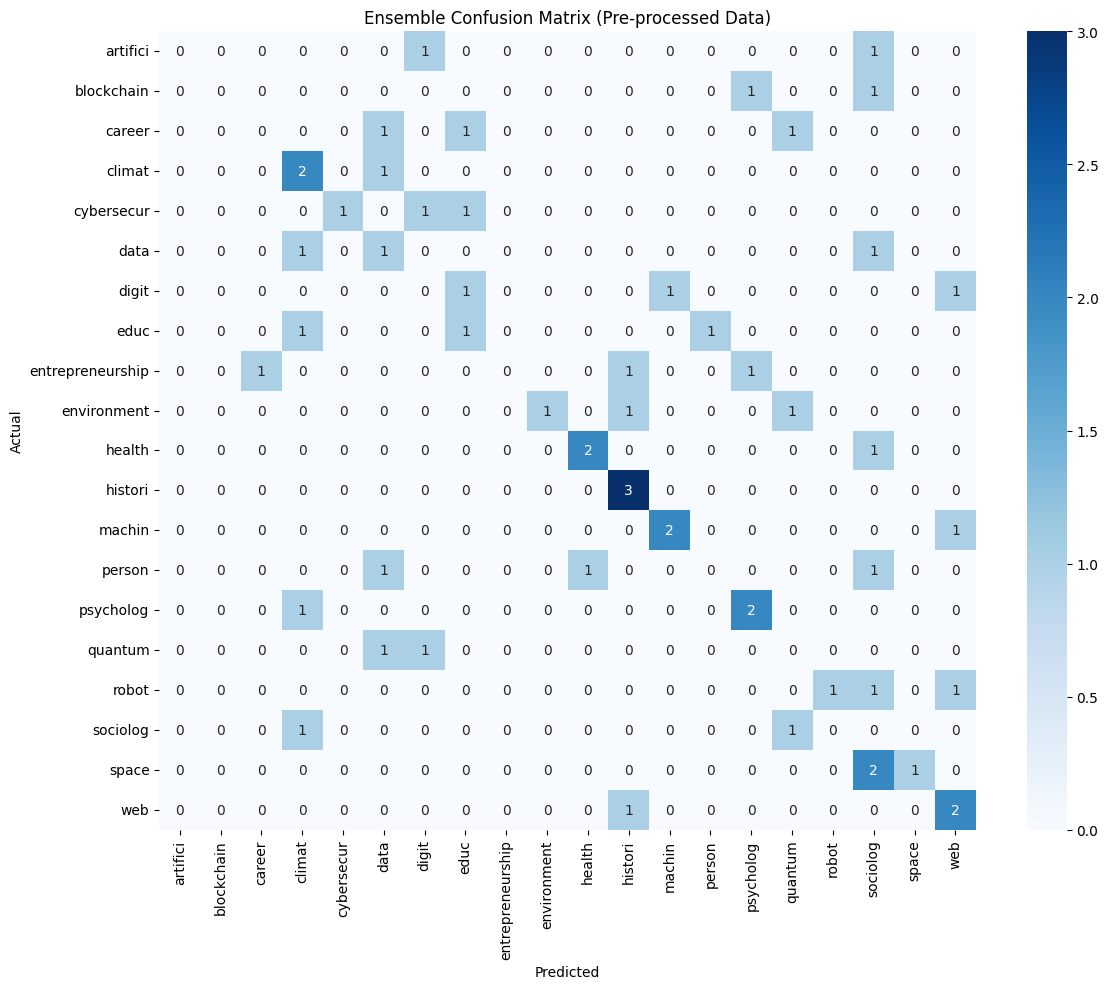

In [1]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
X_resampled = X_resampled.flatten()
df_balanced = pd.DataFrame({'text': X_resampled, 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets for both models
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: RoBERTa ---
print("\n--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Ensemble Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_rb = trainer_rb.predict(val_dataset_rb)

probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_rb) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nEnsemble Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Ensemble Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_ensemble_preprocessed.png")
print("Ensemble confusion matrix saved as confusion_matrix_ensemble_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Ensemble ---
print("--- Ensemble Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_rb = tokenize([test_text], roberta_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}

model_db.eval()
model_rb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_rb = model_rb(**inputs_rb).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_rb_inf = torch.softmax(logits_rb, dim=1)

    avg_probs_inf = (probs_db_inf + probs_rb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.996900
40,3.019400
60,3.007800
80,3.004200
100,3.009100
120,2.992000
140,2.992000
160,2.977000
180,2.963500
200,2.952400


Step,Training Loss
20,2.996900
40,3.019400
60,3.007800
80,3.004200
100,3.009100
120,2.992000
140,2.992000
160,2.977000
180,2.963500
200,2.952400



--- Training ALBERT Model ---


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.068200
40,3.024700
60,3.086600
80,3.047600
100,3.036200
120,2.986500
140,2.895000
160,2.713800
180,2.586000
200,2.369000




--- Evaluating Hybrid (RoBERTa + ALBERT) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       1.00      0.33      0.50         3
          climat       0.40      0.67      0.50         3
      cybersecur       0.50      0.33      0.40         3
            data       0.67      0.67      0.67         3
           digit       0.00      0.00      0.00         3
            educ       0.67      0.67      0.67         3
entrepreneurship       0.50      0.33      0.40         3
     environment       0.67      0.67      0.67         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.50      0.67      0.57         3
          person       0.50      0.33      0.40         3
       psycholog       0.67      0.67      0.67         3
         quantum       1.00      

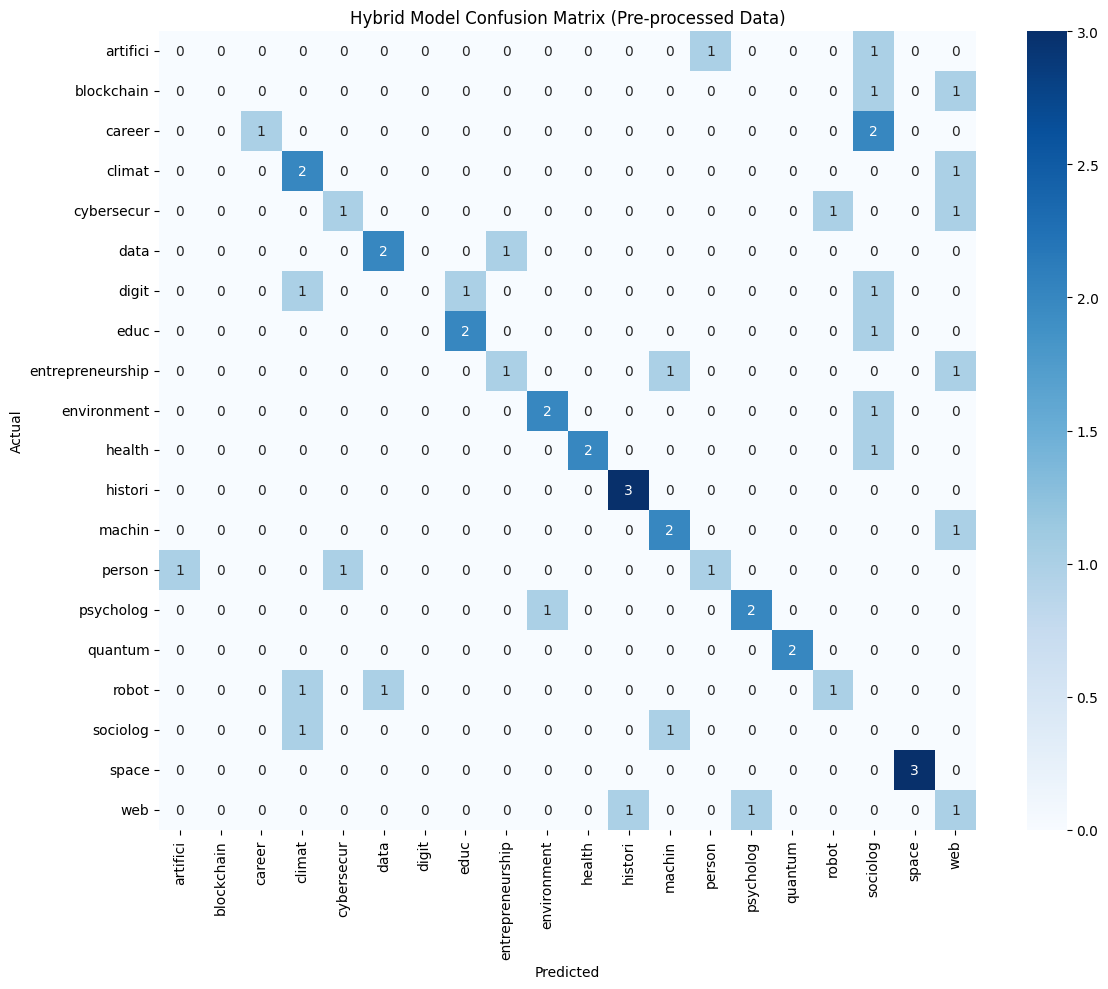

In [6]:
# Roberta + Albert
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    AlbertTokenizer, AlbertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data
df = pd.read_csv("output_part_1.csv")
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)
train_encodings_albert = tokenize(train_df['text'], albert_tokenizer)
val_encodings_albert = tokenize(val_df['text'], albert_tokenizer)

train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)
train_dataset_albert = TopicDataset(train_encodings_albert, train_df['label'].values)
val_dataset_albert = TopicDataset(val_encodings_albert, val_df['label'].values)

# --- Train Model 1: RoBERTa ---
print("--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()

# --- Train Model 2: ALBERT ---
print("\n--- Training ALBERT Model ---")
model_albert = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)
training_args_albert = TrainingArguments(
    output_dir='./ensemble/albert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_albert = Trainer(model=model_albert, args=training_args_albert, train_dataset=train_dataset_albert)
trainer_albert.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (RoBERTa + ALBERT) Model ---")
preds_rb = trainer_rb.predict(val_dataset_rb)
preds_albert = trainer_albert.predict(val_dataset_albert)

probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
probs_albert = torch.softmax(torch.from_numpy(preds_albert.predictions), dim=1).numpy()
avg_probs = (probs_rb + probs_albert) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_rb = tokenize([test_text], roberta_tokenizer)
inputs_albert = tokenize([test_text], albert_tokenizer)

device = trainer_rb.args.device
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}
inputs_albert = {k: v.to(device) for k, v in inputs_albert.items()}

model_rb.eval()
model_albert.eval()
with torch.no_grad():
    logits_rb = model_rb(**inputs_rb).logits
    logits_albert = model_albert(**inputs_albert).logits

    probs_rb_inf = torch.softmax(logits_rb, dim=1)
    probs_albert_inf = torch.softmax(logits_albert, dim=1)

    avg_probs_inf = (probs_rb_inf + probs_albert_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic_list'] = df['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df = df[['text', 'topic_list']]
df.dropna(subset=['topic_list', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: MultiLabelBinarizer for multi-label classification
mlb = MultiLabelBinarizer()
df['label_vec'] = mlb.fit_transform(df['topic_list']).tolist()
num_labels = len(mlb.classes_)
print("--- MultiLabelBinarizer ---")
print(f"Number of unique topics: {num_labels}")
print("Example label vector:", df['label_vec'].iloc[0])
print("\n" + "="*50 + "\n")

# Step 5: Handle Class Imbalance (optional, for multi-label use original distribution)
# For multi-label, oversampling is tricky. Here, we skip it for simplicity.

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42
)
print("--- Data Splitting ---")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print("\n" + "="*50 + "\n")

# Step 7: Create PyTorch Datasets for both models
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)  # float for BCEWithLogitsLoss

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label_vec'].tolist())
val_dataset_db = TopicDataset(val_encodings_db, val_df['label_vec'].tolist())
train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label_vec'].tolist())
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label_vec'].tolist())

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=num_labels, problem_type='multi_label_classification'
)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20,
    report_to=[]
)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = (pred.predictions > 0).astype(int)  # threshold at 0 for BCEWithLogitsLoss
    f1_micro = f1_score(labels, preds, average='micro', zero_division=0)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
    return {'f1_micro': f1_micro, 'f1_macro': f1_macro}
trainer_db = Trainer(
    model=model_db,
    args=training_args_db,
    train_dataset=train_dataset_db,
    eval_dataset=val_dataset_db,
    compute_metrics=compute_metrics,
)
trainer_db.train()

# --- Train Model 2: RoBERTa ---
print("\n--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=num_labels, problem_type='multi_label_classification'
)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed',
    num_train_epochs=12,
    per_device_train_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=20,
    report_to=[]
)
trainer_rb = Trainer(
    model=model_rb,
    args=training_args_rb,
    train_dataset=train_dataset_rb,
    eval_dataset=val_dataset_rb,
    compute_metrics=compute_metrics,
)
trainer_rb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Ensemble Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_rb = trainer_rb.predict(val_dataset_rb)

probs_db = torch.sigmoid(torch.from_numpy(preds_db.predictions)).numpy()
probs_rb = torch.sigmoid(torch.from_numpy(preds_rb.predictions)).numpy()
avg_probs = (probs_db + probs_rb) / 2

y_pred_ensemble = (avg_probs > 0.5).astype(int)
y_true = np.array(val_df['label_vec'].tolist())

print("\nEnsemble Classification Report (micro F1):", f1_score(y_true, y_pred_ensemble, average='micro', zero_division=0))
print("Ensemble Classification Report (macro F1):", f1_score(y_true, y_pred_ensemble, average='macro', zero_division=0))
print("\nDetailed Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=mlb.classes_))

# --- Step 9: Inference with Ensemble ---
print("--- Ensemble Inference Example ---")
test_text = "organ choos concern eye stage three point despit senior serv citizen idea u"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_rb = tokenize([test_text], roberta_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}

model_db.eval()
model_rb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_rb = model_rb(**inputs_rb).logits

    probs_db_inf = torch.sigmoid(logits_db)
    probs_rb_inf = torch.sigmoid(logits_rb)

    avg_probs_inf = (probs_db_inf + probs_rb_inf) / 2

    pred_labels = (avg_probs_inf > 0.5).cpu().numpy()[0]
    pred_topics = mlb.inverse_transform([pred_labels])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topics: {pred_topics}")

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- MultiLabelBinarizer ---
Number of unique topics: 30
Example label vector: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


--- Data Splitting ---
Training samples: 160
Validation samples: 40


--- Training DistilBERT Model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,0.586500
40,0.438900
60,0.368900
80,0.321700
100,0.292300
120,0.271100
140,0.254600
160,0.245600
180,0.239600
200,0.235500



--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,0.537000
40,0.347300
60,0.289900
80,0.261000
100,0.244100
120,0.234400
140,0.228000
160,0.224000
180,0.221600
200,0.219400




--- Evaluating Ensemble Model ---



Ensemble Classification Report (micro F1): 0.0
Ensemble Classification Report (macro F1): 0.0

Detailed Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         0
           chang       0.00      0.00      0.00         2
          climat       0.00      0.00      0.00         2
          comput       0.00      0.00      0.00         1
      cybersecur       0.00      0.00      0.00         2
            data       0.00      0.00      0.00         4
         develop       0.00      0.00      0.00         2
           digit       0.00      0.00      0.00         3
            educ       0.00      0.00      0.00         2
entrepreneurship       0.00      0.00      0.00         2
     environment       0.00      0.00      0.00         1
          explor       0.00      0.00      0.00         0


AttributeError: 'list' object has no attribute 'shape'

--- Data Loading (Pre-processed Data) ---
Data shape: (200, 2)


--- Training DistilBERT Model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.011600
40,2.996400
60,2.980500
80,2.928600
100,2.887700
120,2.785500
140,2.701400
160,2.568500
180,2.512700
200,2.436500



--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.997600
40,3.017600
60,3.011500
80,3.000300
100,3.005700
120,2.994700
140,2.946600
160,2.893500
180,2.823200
200,2.766500




--- Evaluating Hybrid (Ensemble) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.40      0.67      0.50         3
      cybersecur       1.00      0.33      0.50         3
            data       0.20      0.33      0.25         3
           digit       0.00      0.00      0.00         3
            educ       0.25      0.33      0.29         3
entrepreneurship       0.00      0.00      0.00         3
     environment       1.00      0.33      0.50         3
          health       0.29      0.67      0.40         3
         histori       0.50      1.00      0.67         3
          machin       0.50      0.33      0.40         3
          person       0.00      0.00      0.00         3
       psycholog       1.00      0.67      0.80         3
         quantum       0.25      

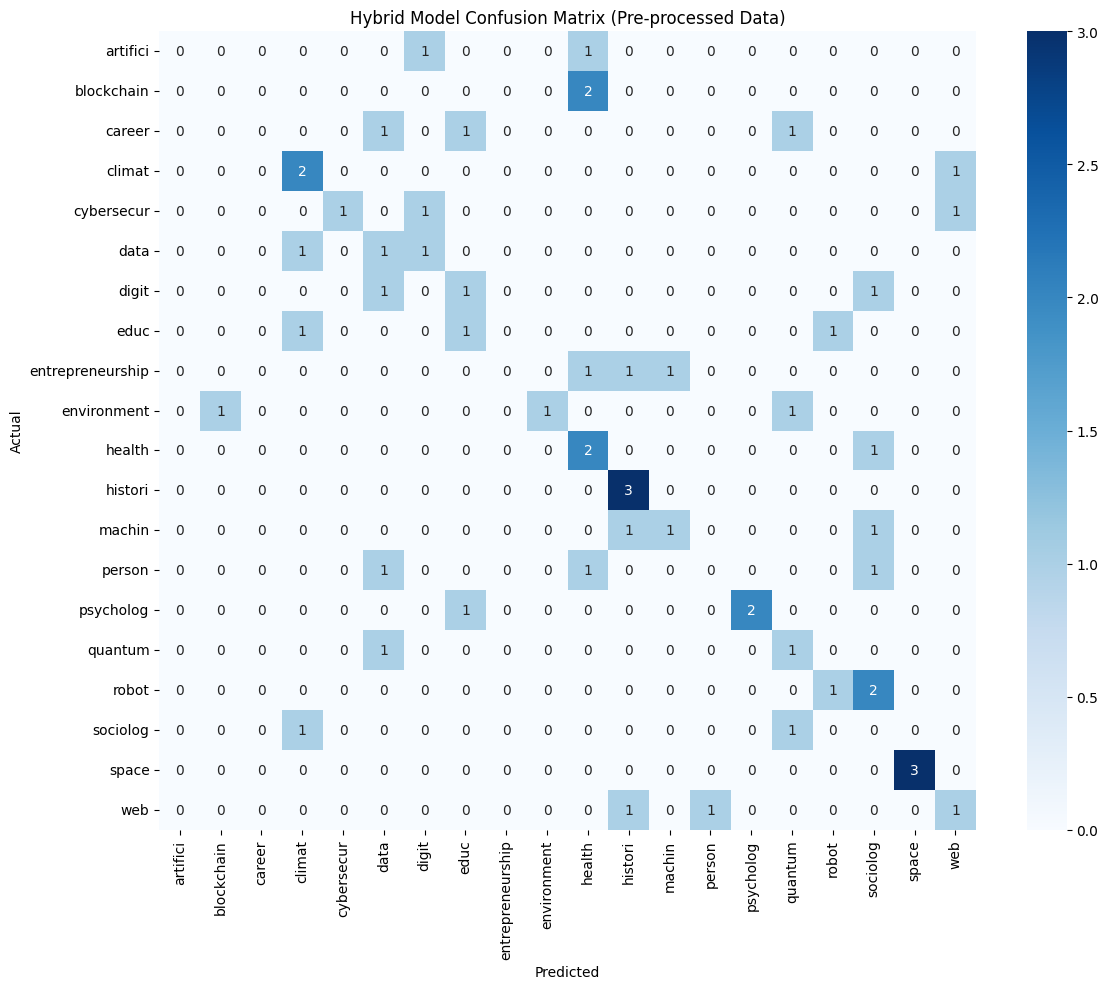

In [ ]:
            # Approach 2
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

def process_text_column(series):
    processed_texts = []
    for item in series:
      if isinstance(item, str) and item.startswith('['):
        try:
          word_list = ast.literal_eval(item)
          processed_texts.append(' '.join(word_list))
        except (ValueError, SyntaxError):
          processed_texts.append('')
      else:
        processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
  if col in df.columns:
    df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else '')
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading (Pre-processed Data) ---")
print("Data shape:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: RoBERTa ---
print("\n--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (Ensemble) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_rb = trainer_rb.predict(val_dataset_rb)

probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()

avg_probs = (probs_db + probs_rb) / 2
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"
inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_rb = tokenize([test_text], roberta_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}

model_db.eval()
model_rb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_rb = model_rb(**inputs_rb).logits
    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_rb_inf = torch.softmax(logits_rb, dim=1)
    avg_probs_inf = (probs_db_inf + probs_rb_inf) / 2
    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Roberta + MobileBERT**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.996900
40,3.019400
60,3.007800
80,3.004200
100,3.009100
120,2.992000
140,2.992000
160,2.977000
180,2.963500
200,2.952400



--- Training MobileBERT Model ---


Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,5773814.000000
40,38795.118800
60,3.459200
80,3.135000
100,2.962100
120,2.921600
140,2.701800
160,2.579200
180,2.567700
200,2.378500




--- Evaluating Hybrid (RoBERTa + MobileBERT) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.33      0.33      0.33         3
          climat       0.67      0.67      0.67         3
      cybersecur       0.50      0.33      0.40         3
            data       0.33      0.33      0.33         3
           digit       0.00      0.00      0.00         3
            educ       0.50      0.33      0.40         3
entrepreneurship       0.00      0.00      0.00         3
     environment       0.33      0.33      0.33         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.33      0.67      0.44         3
          person       0.00      0.00      0.00         3
       psycholog       0.33      0.67      0.44         3
         quantum       0.00      

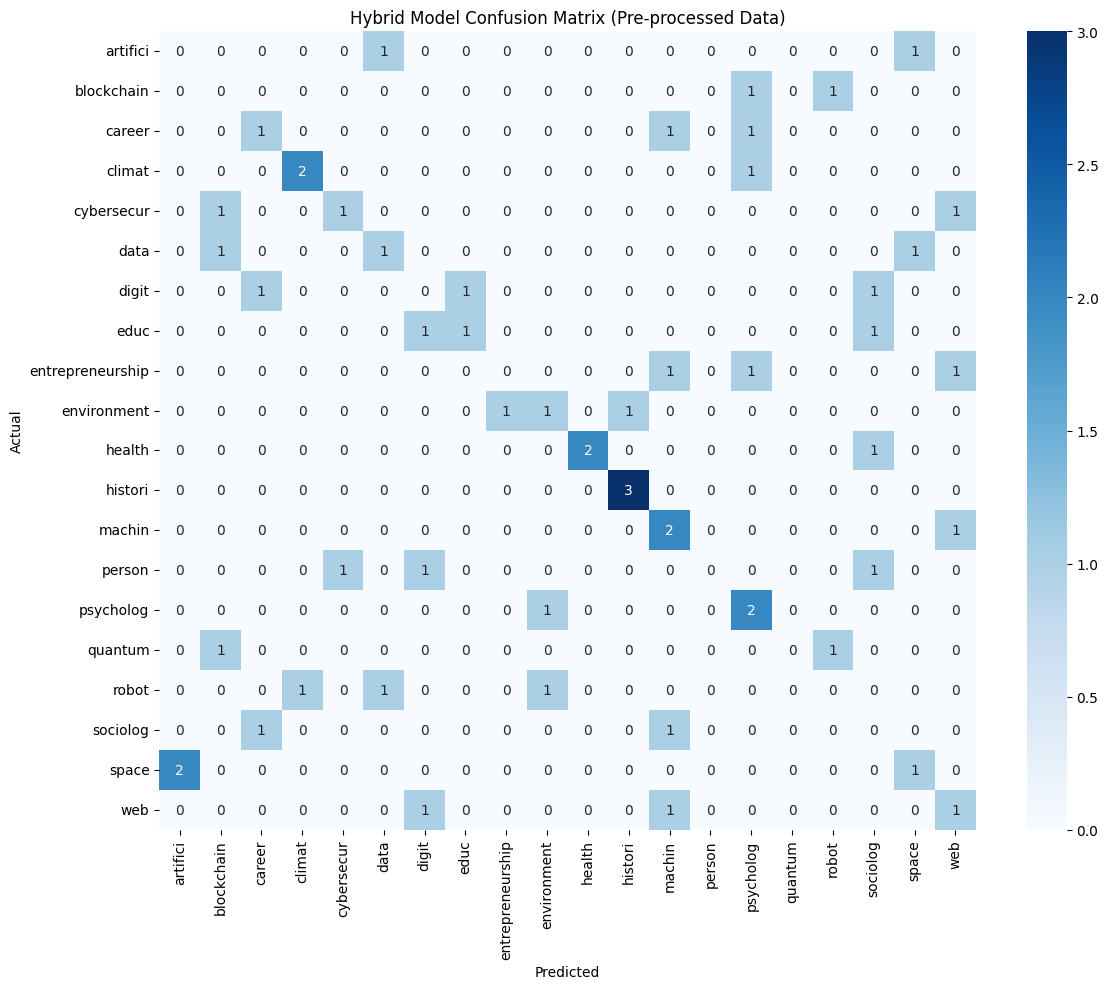

In [2]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)
train_encodings_mb = tokenize(train_df['text'], mobilebert_tokenizer)
val_encodings_mb = tokenize(val_df['text'], mobilebert_tokenizer)

train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)
train_dataset_mb = TopicDataset(train_encodings_mb, train_df['label'].values)
val_dataset_mb = TopicDataset(val_encodings_mb, val_df['label'].values)

# --- Train Model 1: RoBERTa ---
print("--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()

# --- Train Model 2: MobileBERT ---
print("\n--- Training MobileBERT Model ---")
model_mb = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
training_args_mb = TrainingArguments(
    output_dir='./ensemble/mobilebert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_mb = Trainer(model=model_mb, args=training_args_mb, train_dataset=train_dataset_mb)
trainer_mb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (RoBERTa + MobileBERT) Model ---")
preds_rb = trainer_rb.predict(val_dataset_rb)
preds_mb = trainer_mb.predict(val_dataset_mb)

probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
probs_mb = torch.softmax(torch.from_numpy(preds_mb.predictions), dim=1).numpy()
avg_probs = (probs_rb + probs_mb) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_rb = tokenize([test_text], roberta_tokenizer)
inputs_mb = tokenize([test_text], mobilebert_tokenizer)

device = trainer_rb.args.device
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}
inputs_mb = {k: v.to(device) for k, v in inputs_mb.items()}

model_rb.eval()
model_mb.eval()
with torch.no_grad():
    logits_rb = model_rb(**inputs_rb).logits
    logits_mb = model_mb(**inputs_mb).logits

    probs_rb_inf = torch.softmax(logits_rb, dim=1)
    probs_mb_inf = torch.softmax(logits_mb, dim=1)

    avg_probs_inf = (probs_rb_inf + probs_mb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Roberta + Electra**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

--- Training RoBERTa Model ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,2.996900
40,3.019400
60,3.007800
80,3.004200
100,3.009100
120,2.992000
140,2.992000
160,2.977000
180,2.963500
200,2.952400



--- Training ELECTRA Model ---


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.007800
40,3.009800
60,3.011500
80,2.994400
100,2.991000
120,2.973200
140,2.962600
160,2.932800
180,2.914400
200,2.892200




--- Evaluating Hybrid (RoBERTa + ELECTRA) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.33      0.67      0.44         3
      cybersecur       1.00      0.33      0.50         3
            data       1.00      0.33      0.50         3
           digit       0.00      0.00      0.00         3
            educ       0.00      0.00      0.00         3
entrepreneurship       0.00      0.00      0.00         3
     environment       0.00      0.00      0.00         3
          health       1.00      0.67      0.80         3
         histori       0.75      1.00      0.86         3
          machin       0.67      0.67      0.67         3
          person       0.00      0.00      0.00         3
       psycholog       0.50      0.67      0.57         3
         quantum       0.00      

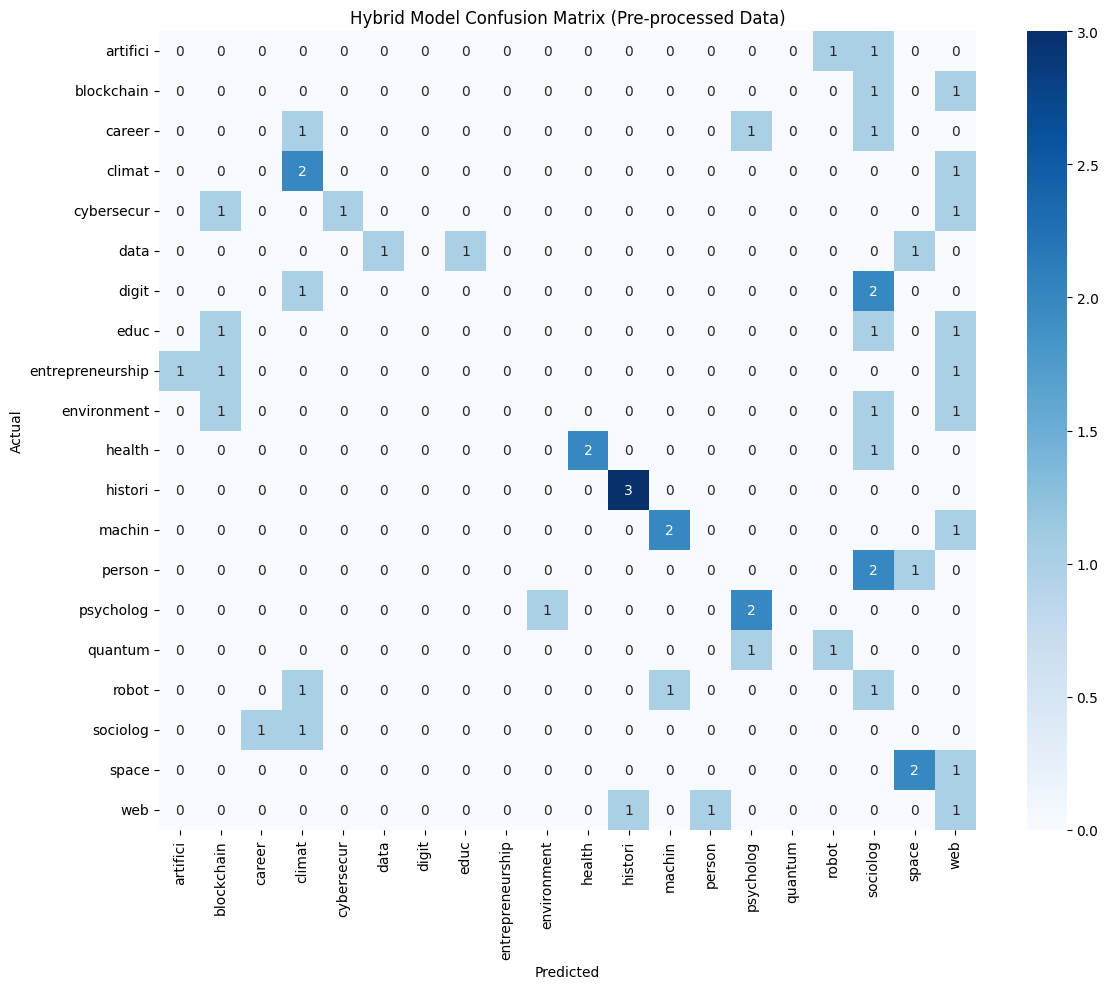

In [3]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    ElectraTokenizer, ElectraForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_rb = tokenize(train_df['text'], roberta_tokenizer)
val_encodings_rb = tokenize(val_df['text'], roberta_tokenizer)
train_encodings_electra = tokenize(train_df['text'], electra_tokenizer)
val_encodings_electra = tokenize(val_df['text'], electra_tokenizer)

train_dataset_rb = TopicDataset(train_encodings_rb, train_df['label'].values)
val_dataset_rb = TopicDataset(val_encodings_rb, val_df['label'].values)
train_dataset_electra = TopicDataset(train_encodings_electra, train_df['label'].values)
val_dataset_electra = TopicDataset(val_encodings_electra, val_df['label'].values)

# --- Train Model 1: RoBERTa ---
print("--- Training RoBERTa Model ---")
model_rb = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
training_args_rb = TrainingArguments(
    output_dir='./ensemble/roberta_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_rb = Trainer(model=model_rb, args=training_args_rb, train_dataset=train_dataset_rb)
trainer_rb.train()

# --- Train Model 2: ELECTRA ---
print("\n--- Training ELECTRA Model ---")
model_electra = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_labels)
training_args_electra = TrainingArguments(
    output_dir='./ensemble/electra_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_electra = Trainer(model=model_electra, args=training_args_electra, train_dataset=train_dataset_electra)
trainer_electra.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (RoBERTa + ELECTRA) Model ---")
preds_rb = trainer_rb.predict(val_dataset_rb)
preds_electra = trainer_electra.predict(val_dataset_electra)

probs_rb = torch.softmax(torch.from_numpy(preds_rb.predictions), dim=1).numpy()
probs_electra = torch.softmax(torch.from_numpy(preds_electra.predictions), dim=1).numpy()
avg_probs = (probs_rb + probs_electra) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_rb = tokenize([test_text], roberta_tokenizer)
inputs_electra = tokenize([test_text], electra_tokenizer)

device = trainer_rb.args.device
inputs_rb = {k: v.to(device) for k, v in inputs_rb.items()}
inputs_electra = {k: v.to(device) for k, v in inputs_electra.items()}

model_rb.eval()
model_electra.eval()
with torch.no_grad():
    logits_rb = model_rb(**inputs_rb).logits
    logits_electra = model_electra(**inputs_electra).logits

    probs_rb_inf = torch.softmax(logits_rb, dim=1)
    probs_electra_inf = torch.softmax(logits_electra, dim=1)

    avg_probs_inf = (probs_rb_inf + probs_electra_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Distil + Electra**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

--- Training DistilBERT Model ---


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.011600
40,2.996400
60,2.980500
80,2.928600
100,2.887700
120,2.785500
140,2.701400
160,2.568500
180,2.512700
200,2.436500



--- Training ELECTRA Model ---


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.007800
40,3.009800
60,3.011500
80,2.994400
100,2.991000
120,2.973200
140,2.962600
160,2.932800
180,2.914400
200,2.892200




--- Evaluating Hybrid (DistilBERT + ELECTRA) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.00      0.00      0.00         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.67      0.67      0.67         3
      cybersecur       1.00      0.33      0.50         3
            data       0.20      0.33      0.25         3
           digit       0.00      0.00      0.00         3
            educ       1.00      0.67      0.80         3
entrepreneurship       1.00      0.33      0.50         3
     environment       0.67      0.67      0.67         3
          health       0.67      0.67      0.67         3
         histori       1.00      1.00      1.00         3
          machin       0.40      0.67      0.50         3
          person       0.00      0.00      0.00         3
       psycholog       1.00      0.67      0.80         3
         quantum       0.50      

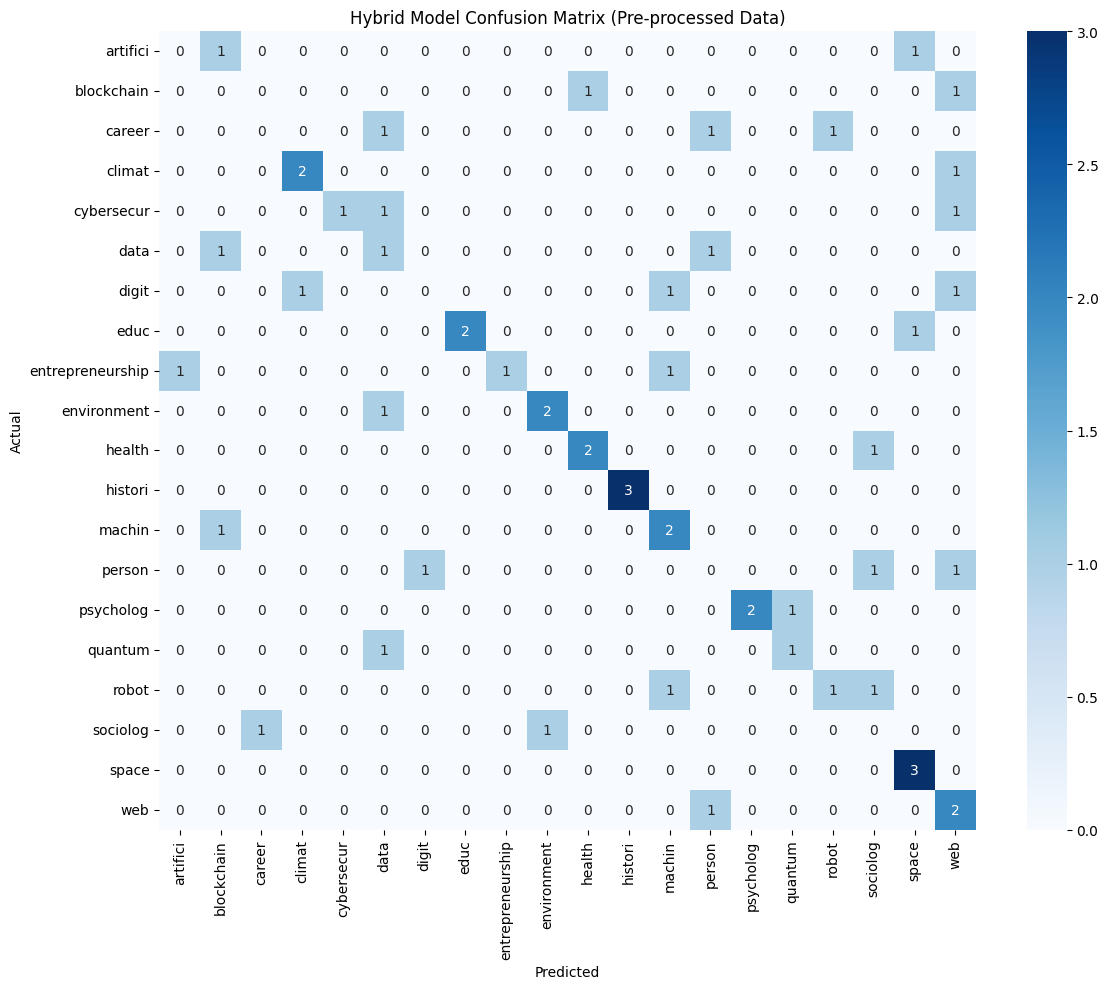

In [4]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    ElectraTokenizer, ElectraForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
electra_tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_df['text'], distilbert_tokenizer)
val_encodings_db = tokenize(val_df['text'], distilbert_tokenizer)
train_encodings_electra = tokenize(train_df['text'], electra_tokenizer)
val_encodings_electra = tokenize(val_df['text'], electra_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_electra = TopicDataset(train_encodings_electra, train_df['label'].values)
val_dataset_electra = TopicDataset(val_encodings_electra, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: ELECTRA ---
print("\n--- Training ELECTRA Model ---")
model_electra = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator', num_labels=num_labels)
training_args_electra = TrainingArguments(
    output_dir='./ensemble/electra_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_electra = Trainer(model=model_electra, args=training_args_electra, train_dataset=train_dataset_electra)
trainer_electra.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (DistilBERT + ELECTRA) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_electra = trainer_electra.predict(val_dataset_electra)

probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_electra = torch.softmax(torch.from_numpy(preds_electra.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_electra) / 2

y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_electra = tokenize([test_text], electra_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_electra = {k: v.to(device) for k, v in inputs_electra.items()}

model_db.eval()
model_electra.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_electra = model_electra(**inputs_electra).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_electra_inf = torch.softmax(logits_electra, dim=1)

    avg_probs_inf = (probs_db_inf + probs_electra_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

**Top2Vec + Distil Bert Model**

--- Data Loading and Preparation (from output_part_1.csv) ---
Data shape after processing: (200, 2)


--- Training DistilBERT Model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.010100
40,3.004500
60,2.997700
80,2.959200
100,2.928300
120,2.840200
140,2.766500
160,2.656600
180,2.600900
200,2.506800



--- Generating TF-IDF Features ---

--- Training Logistic Regression on TF-IDF Features ---


--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---



Hybrid Model Classification Report:
                   precision    recall  f1-score   support

        artifici       0.25      0.50      0.33         2
      blockchain       0.00      0.00      0.00         2
          career       0.00      0.00      0.00         3
          climat       0.50      0.67      0.57         3
      cybersecur       0.50      0.33      0.40         3
            data       1.00      0.33      0.50         3
           digit       0.00      0.00      0.00         3
            educ       0.50      0.67      0.57         3
entrepreneurship       1.00      0.33      0.50         3
     environment       1.00      0.67      0.80         3
          health       0.67      0.67      0.67         3
         histori       1.00      1.00      1.00         3
          machin       1.00      0.67      0.80         3
          person       0.50      0.33      0.40         3
       psycholog       0.50      0.67      0.57         3
         quantum       0.67      

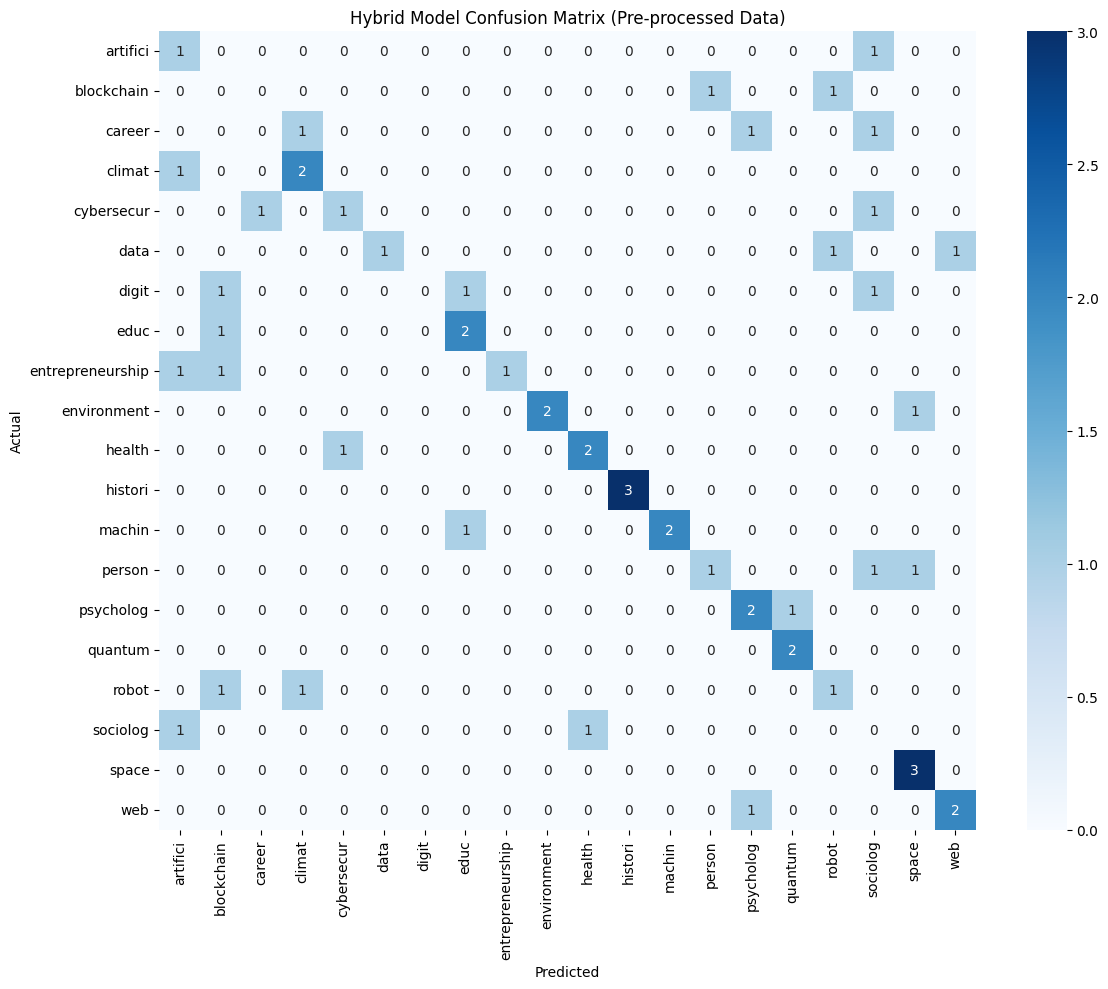

In [10]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels and Handle Class Imbalance
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 5: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values

# --- PART 1: Train the DistilBERT Supervised Classifier ---

# Step 6: Prepare DistilBERT Datasets
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_dataset_db = ClassificationDataset(train_encodings_db, train_labels)
val_dataset_db = ClassificationDataset(val_encodings_db, val_labels)

# Step 7: Train DistilBERT
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./hybrid/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- PART 2: Train the TF-IDF + Logistic Regression Classifier ---

# Step 8: Create TF-IDF Features from Text
print("\n--- Generating TF-IDF Features ---")
# Since the text is already tokenized and cleaned, we can use it directly.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

# Step 9: Train Logistic Regression on TF-IDF Features
print("\n--- Training Logistic Regression on TF-IDF Features ---")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, train_labels)

# --- PART 3: Ensemble Predictions and Evaluate ---
print("\n" + "="*50 + "\n")
print("--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---")

# Step 10: Get Probabilities from Both Paths
# Path 1: DistilBERT
preds_db = trainer_db.predict(val_dataset_db)
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()

# Path 2: TF-IDF + Logistic Regression
probs_tfidf = logreg.predict_proba(X_val_tfidf)

# Step 11: Average the probabilities with weighting
# Giving slightly more weight to the transformer model
avg_probs = (0.6 * probs_db) + (0.4 * probs_tfidf)
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_labels

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_distilbert_tfidf.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_distilbert_tfidf.png")
# --- Step 12: Inference with Hybrid Model ---
print("\n" + "="*50 + "\n")
print("--- Hybrid Model Inference Example ---")
test_text = "Marriage best film dream why wish."

# --- Path 1: Get DistilBERT prediction ---
# Tokenize the text for DistilBERT
inputs_db = tokenize([test_text], distilbert_tokenizer)
# Move inputs to the correct device
device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}

model_db.eval()
with torch.no_grad():
    # Get logits and convert to probabilities
    logits_db = model_db(**inputs_db).logits
    probs_db_inf = torch.softmax(logits_db, dim=1).cpu().numpy()

# --- Path 2: Get TF-IDF + Logistic Regression prediction ---
# Transform the text using the already-fitted TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform([test_text])
# Get probabilities from the logistic regression model
probs_tfidf_inf = logreg.predict_proba(X_test_tfidf)

# --- Ensemble the predictions ---
# Average the probabilities using the same weighting as in evaluation
avg_probs_inf = (0.6 * probs_db_inf) + (0.4 * probs_tfidf_inf)

# Get the final prediction
pred_label_index = np.argmax(avg_probs_inf, axis=1)[0]
pred_topic = label_encoder.inverse_transform([pred_label_index])[0]

print(f"Input Text: \"{test_text}\"")
print(f"Predicted topic: {pred_topic}")

In [ ]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    MobileBertTokenizer, MobileBertForSequenceClassification,
    Trainer, TrainingArguments
)
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from output_part_1.csv
df = pd.read_csv("output_part_1.csv")

# Helper function to safely evaluate string-lists and join them
def process_text_column(series):
    processed_texts = []
    for item in series:
        if isinstance(item, str) and item.startswith('['):
            try:
                word_list = ast.literal_eval(item)
                processed_texts.append(' '.join(word_list))
            except (ValueError, SyntaxError):
                processed_texts.append('')
        else:
            processed_texts.append('')
    return processed_texts

text_columns = ['question_text'] + [f'answer_item_{i}' for i in range(1, 10)]
for col in text_columns:
    if col in df.columns:
        df[col] = process_text_column(df[col])

df['text'] = df[text_columns].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
# Taking only the first topic for single-label classification
df['topic'] = df['topic'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x.startswith('[') and len(ast.literal_eval(x)) > 0 else None)
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from output_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

# Step 5: Handle Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 6: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values

# Step 7: Create PyTorch Datasets
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenizers
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')

def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_encodings_mb = tokenize(train_texts, mobilebert_tokenizer)
val_encodings_mb = tokenize(val_texts, mobilebert_tokenizer)

train_dataset_db = TopicDataset(train_encodings_db, train_df['label'].values)
val_dataset_db = TopicDataset(val_encodings_db, val_df['label'].values)
train_dataset_mb = TopicDataset(train_encodings_mb, train_df['label'].values)
val_dataset_mb = TopicDataset(val_encodings_mb, val_df['label'].values)

# --- Train Model 1: DistilBERT ---
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./ensemble/distilbert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- Train Model 2: MobileBERT ---
print("\n--- Training MobileBERT Model ---")
model_mb = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=num_labels)
training_args_mb = TrainingArguments(
    output_dir='./ensemble/mobilebert_preprocessed', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_mb = Trainer(model=model_mb, args=training_args_mb, train_dataset=train_dataset_mb)
trainer_mb.train()
print("\n" + "="*50 + "\n")

# --- Step 8: Ensemble Predictions and Evaluate ---
print("--- Evaluating Hybrid (DistilBERT + MobileBERT) Model ---")
preds_db = trainer_db.predict(val_dataset_db)
preds_mb = trainer_mb.predict(val_dataset_mb)

# Convert logits to probabilities and average them
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()
probs_mb = torch.softmax(torch.from_numpy(preds_mb.predictions), dim=1).numpy()
avg_probs = (probs_db + probs_mb) / 2

# Use argmax to get the single best prediction
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_df['label'].values

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (Pre-processed Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_preprocessed.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_preprocessed.png")
print("\n" + "="*50 + "\n")

# --- Step 9: Inference with Hybrid Model ---
print("--- Hybrid Model Inference Example ---")
test_text = "marriag best film dream wish"

inputs_db = tokenize([test_text], distilbert_tokenizer)
inputs_mb = tokenize([test_text], mobilebert_tokenizer)

device = trainer_db.args.device
inputs_db = {k: v.to(device) for k, v in inputs_db.items()}
inputs_mb = {k: v.to(device) for k, v in inputs_mb.items()}

model_db.eval()
model_mb.eval()
with torch.no_grad():
    logits_db = model_db(**inputs_db).logits
    logits_mb = model_mb(**inputs_mb).logits

    probs_db_inf = torch.softmax(logits_db, dim=1)
    probs_mb_inf = torch.softmax(logits_mb, dim=1)

    avg_probs_inf = (probs_db_inf + probs_mb_inf) / 2

    pred_label = avg_probs_inf.argmax(dim=1).item()
    pred_topic = label_encoder.inverse_transform([pred_label])[0]

    print(f"Input Text: \"{test_text}\"")
    print(f"Predicted topic: {pred_topic}")

--- Data Loading and Preparation (from original_part_1.csv) ---
Data shape after processing: (200, 2)


--- Training DistilBERT Model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
20,3.012300
40,2.994500
60,2.981700
80,2.927000
100,2.876800
120,2.787100
140,2.658100
160,2.550500
180,2.504700
200,2.396700



--- Generating TF-IDF Features ---

--- Training Logistic Regression on TF-IDF Features ---


--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---



Hybrid Model Classification Report:
                          precision    recall  f1-score   support

Artificial Intelligence       0.00      0.00      0.00         2
             Blockchain       0.00      0.00      0.00         2
     Career Development       0.00      0.00      0.00         3
         Climate Change       0.67      0.67      0.67         3
          Cybersecurity       0.50      0.33      0.40         3
           Data Science       0.20      0.33      0.25         3
      Digital Marketing       0.00      0.00      0.00         3
              Education       1.00      0.67      0.80         3
       Entrepreneurship       1.00      0.33      0.50         3
  Environmental Science       0.67      0.67      0.67         3
       Health & Fitness       1.00      0.67      0.80         3
                History       1.00      1.00      1.00         3
       Machine Learning       0.50      0.67      0.57         3
       Personal Finance       0.00      0.00      0

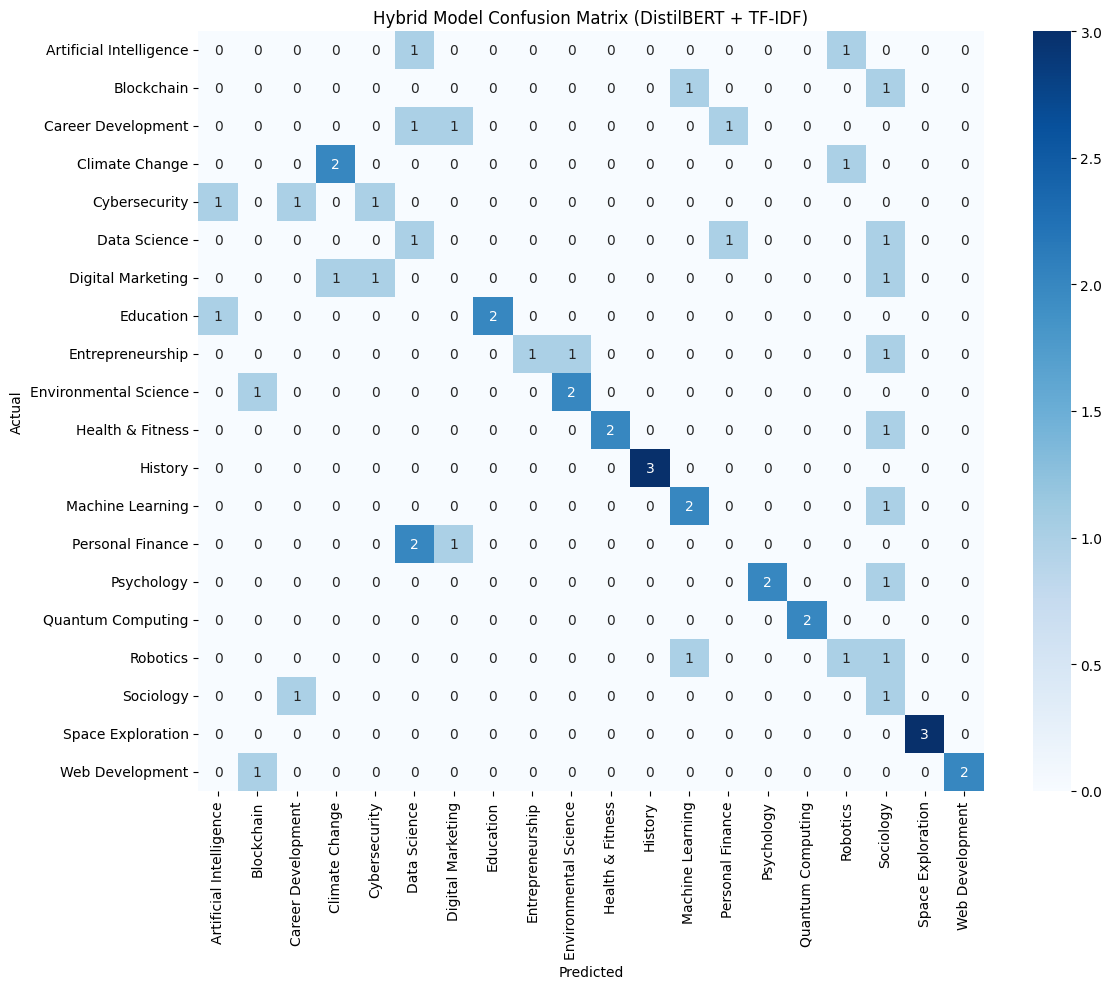

In [8]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn torch transformers "imbalanced-learn" seaborn matplotlib --quiet

# Step 2: Import libraries
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import ast
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Step 3: Load and preprocess data from original_part_1.csv
df = pd.read_csv("original_part_1.csv")

# Combine question and all answer columns into a single 'text' column for model input.
answer_cols = [f'answer_item_{i}' for i in range(1, 10)]
for col in answer_cols:
    df[col] = df[col].fillna('')

df['text'] = df[['question_text'] + answer_cols].astype(str).agg(' '.join, axis=1)
df['text'] = df['text'].str.strip()
df = df[['text', 'topic']]
df.dropna(subset=['topic', 'text'], inplace=True)
df = df[df['text'] != '']

print("--- Data Loading and Preparation (from original_part_1.csv) ---")
print("Data shape after processing:", df.shape)
print("\n" + "="*50 + "\n")

# Step 4: Encode labels and Handle Class Imbalance
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['topic'])
num_labels = len(label_encoder.classes_)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df['text'].values.reshape(-1, 1), df['label'])
df_balanced = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

# Step 5: Train/Test Split
train_df, val_df = train_test_split(
    df_balanced, test_size=0.2, random_state=42, stratify=df_balanced['label']
)
train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()
train_labels = train_df['label'].values
val_labels = val_df['label'].values

# --- PART 1: Train the DistilBERT Supervised Classifier ---

# Step 6: Prepare DistilBERT Datasets
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts), padding='max_length', truncation=True, max_length=max_length, return_tensors='pt'
    )

class ClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_encodings_db = tokenize(train_texts, distilbert_tokenizer)
val_encodings_db = tokenize(val_texts, distilbert_tokenizer)
train_dataset_db = ClassificationDataset(train_encodings_db, train_labels)
val_dataset_db = ClassificationDataset(val_encodings_db, val_labels)

# Step 7: Train DistilBERT
print("--- Training DistilBERT Model ---")
model_db = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
training_args_db = TrainingArguments(
    output_dir='./hybrid/distilbert', num_train_epochs=12, per_device_train_batch_size=8,
    learning_rate=2e-5, weight_decay=0.01, logging_steps=20, report_to=[]
)
trainer_db = Trainer(model=model_db, args=training_args_db, train_dataset=train_dataset_db)
trainer_db.train()

# --- PART 2: Train the TF-IDF + Logistic Regression Classifier ---

# Step 8: Create TF-IDF Features from Text
print("\n--- Generating TF-IDF Features ---")
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)

# Step 9: Train Logistic Regression on TF-IDF Features
print("\n--- Training Logistic Regression on TF-IDF Features ---")
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_tfidf, train_labels)

# --- PART 3: Ensemble Predictions and Evaluate ---
print("\n" + "="*50 + "\n")
print("--- Evaluating Hybrid (DistilBERT + TF-IDF) Model ---")

# Step 10: Get Probabilities from Both Paths
# Path 1: DistilBERT
preds_db = trainer_db.predict(val_dataset_db)
probs_db = torch.softmax(torch.from_numpy(preds_db.predictions), dim=1).numpy()

# Path 2: TF-IDF + Logistic Regression
probs_tfidf = logreg.predict_proba(X_val_tfidf)

# Step 11: Average the probabilities
# We give slightly more weight to the transformer model as it's generally more powerful
avg_probs = (0.6 * probs_db) + (0.4 * probs_tfidf)
y_pred_ensemble = np.argmax(avg_probs, axis=1)
y_true = val_labels

print("\nHybrid Model Classification Report:\n", classification_report(y_true, y_pred_ensemble, target_names=label_encoder.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Hybrid Model Confusion Matrix (DistilBERT + TF-IDF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig("confusion_matrix_hybrid_distilbert_tfidf.png")
print("Hybrid confusion matrix saved as confusion_matrix_hybrid_distilbert_tfidf.png")